## Ising Hamiltonian

In [1]:
Ni = range(2,21,2)

Ising_normal = [[] for _ in range(1,11)]
Ising_MM = [[] for _ in range(1, 11)]
for i in range(1,11):
    with open("Ising_normal{}.txt".format(i), 'r') as f:
        for line in f.readlines()[1:]:
            words = line.split()
            n = int(words[0])//2 - 1
            Ising_normal[n].append(float(words[1]))
    with open("Ising_MM{}.txt".format(i), 'r') as f:
        for line in f.readlines()[1:]:
            words = line.split()
            n = int(words[0])//2 - 1
            Ising_MM[n].append(float(words[1]))

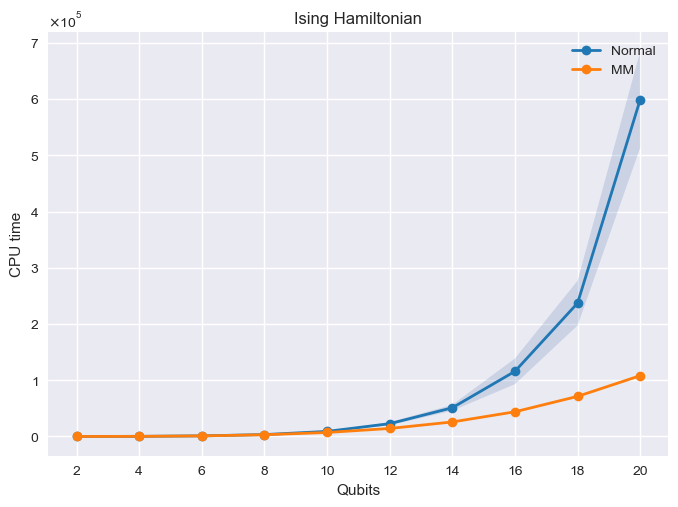

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

yn = np.array([np.mean(Ising_normal[i]) for i in range(10)])
yn_std = np.array([np.std(Ising_normal[i]) for i in range(10)])
ym = np.array([np.mean(Ising_MM[i]) for i in range(10)])
ym_std = np.array([np.std(Ising_MM[i]) for i in range(10)])


fig, ax = plt.subplots(1, 1)
plt.style.use("seaborn")
#clrs = sns.color_palette("husl", 5)
#with sns.axes_style("darkgrid"):
ax.plot(Ni, yn, label="Normal", marker='o',color="tab:blue", linewidth=2)
ax.fill_between(Ni, yn-yn_std, yn+yn_std, alpha=0.2)
ax.plot(Ni, ym, label="MM", marker='o', color="tab:orange",linewidth=2)
ax.fill_between(Ni, ym-ym_std, ym+ym_std, alpha=0.2)


    

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

plt.xticks(Ni) 
plt.legend()
plt.ylabel("CPU time")
plt.xlabel("Qubits")
plt.title("Ising Hamiltonian")
plt.show()
#fig.savefig("ISING.png")

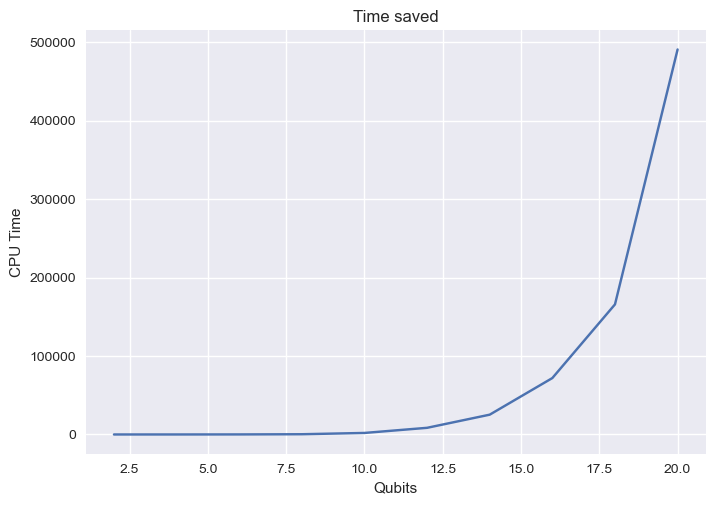

In [7]:
S = []
for i in range(10):
    S.append(yn[i] - ym[i])

with sns.axes_style("darkgrid"):    
    plt.plot(Ni, S)
    plt.title("Time saved")
    plt.ylabel("CPU Time")
    plt.xlabel("Qubits")
    plt.show()

## Molecular Hamiltonian

In [23]:
C = 2  # number of cases
Nm = [2, 4]#, 6, 8, 10, 12]

Mol_normal = [[] for _ in range(C)]
Mol_MM = [[] for _ in range(C)]
for i in range(1,11):
    with open("Molecular_H4_normal_all{}.txt".format(i), 'r') as f:
        j = 0
        for line in f.readlines()[1:]:
            words = line.split()
            Mol_normal[j].append(float(words[2]))
            j += 1
    with open("Molecular_H4_MM_all{}.txt".format(i), 'r') as f:
        j = 0
        for line in f.readlines()[1:]:
            words = line.split()
            Mol_MM[j].append(float(words[2]))
            j += 1

In [25]:
ym_std

array([ 11.16349472, 866.92801625])

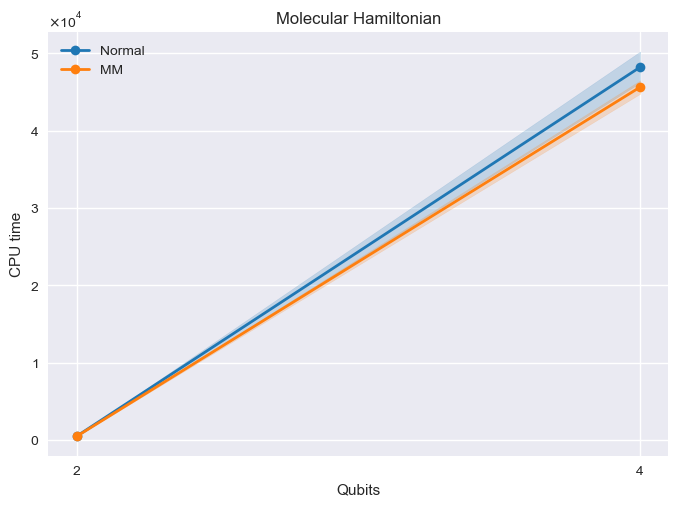

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

yn = np.array([np.mean(Mol_normal[i]) for i in range(C)])
yn_std = np.array([np.std(Mol_normal[i]) for i in range(C)])
ym = np.array([np.mean(Mol_MM[i]) for i in range(C)])
ym_std = np.array([np.std(Mol_MM[i]) for i in range(C)])


fig, ax = plt.subplots(1, 1)
plt.style.use("seaborn")
#clrs = sns.color_palette("husl", 5)
#with sns.axes_style("darkgrid"):
ax.plot(Nm, yn, label="Normal", marker='o',color="tab:blue", linewidth=2)
ax.fill_between(Nm, yn-yn_std, yn+yn_std, color="tab:blue", alpha=0.2)
ax.plot(Nm, ym, label="MM", marker='o', color="tab:orange",linewidth=2)
ax.fill_between(Nm, ym-ym_std, ym+ym_std, color="tab:orange", alpha=0.2)


    

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

plt.xticks(Nm) 
plt.legend()
plt.ylabel("CPU time")
plt.xlabel("Qubits")
plt.title("Molecular Hamiltonian")
plt.show()
#fig.savefig("MOLECULAR.png")

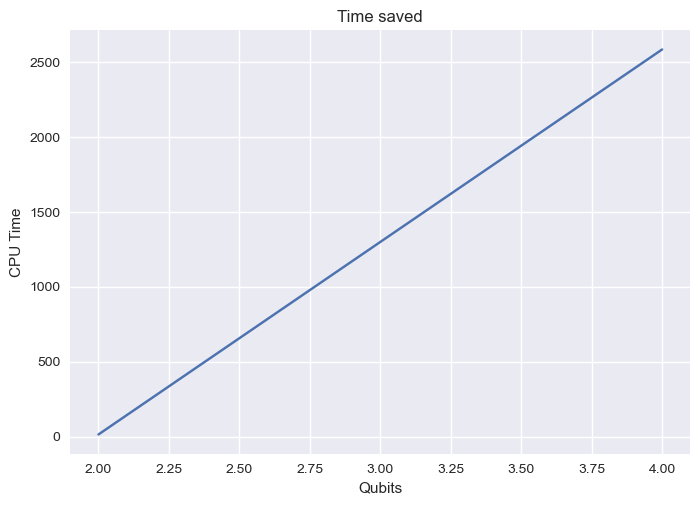

In [34]:
S = []
for i in range(C):
    S.append(yn[i] - ym[i])

with sns.axes_style("darkgrid"):    
    plt.plot(Nm, S)
    plt.title("Time saved")
    plt.ylabel("CPU Time")
    plt.xlabel("Qubits")
    plt.show()

In [27]:
Mol_normal

[306.33009999999996, 10879.0528, 39575.1644, 67880.96290000001, 0, 338375.1761]

In [28]:
Mol_MM

[301.18899999999996,
 10766.8545,
 39087.61439999999,
 66839.8673,
 0,
 345348.99020000006]